In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import statistics
from scipy.stats import pearsonr
import seaborn as sns

import sys
import os

# Use os.getcwd() to get the current working directory if __file__ is not available
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

# Now you can import the necessary modules from the parent directory
from RADARDataCapture import FMCWRADARDataCapture
from MOCAPDataCapture import MOCAPDataCapture
from FPDataCapture import FPDataCapture

Low pass filter

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Low-pass filter function
def lowpass_filter(data, cutoff, fs, order=4):
    """
    Apply a Butterworth lowpass filter to the data.
    
    Args:
        data (np.ndarray): The input data to filter.
        cutoff (float): The cutoff frequency for the lowpass filter.
        fs (float): The sampling frequency.
        order (int): The order of the Butterworth filter.
        
    Returns:
        np.ndarray: The filtered data.
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data


Radar Wobble data

    RADAR_capture  MOCAP_Start_Time  MOCAP_End_Time  RADAR_Start_Frame  \
0  01_MNTRL_RR_V1              7.33           30.57                194   
1  01_MNTRL_RR_V1              7.33           30.57                194   
2  01_MNTRL_RR_V1              7.33           30.57                194   
3  01_MNTRL_RR_V2              7.37           30.40                191   
4  01_MNTRL_RR_V2              7.37           30.40                191   

   RADAR_End_Frame  Seconds_per_Frame  tx  is_final_tx  t_foot_up  t_stable  \
0              831            0.03645   1        False      10.22     11.19   
1              831            0.03645   2        False      18.25     19.05   
2              831            0.03645   3         True      26.24     27.03   
3              822            0.03646   1        False      10.48     11.05   
4              822            0.03646   2        False      18.41     19.07   

   t_break  t_foot_down  frame_foot_up  frame_stable  frame_break  frame_end  
0

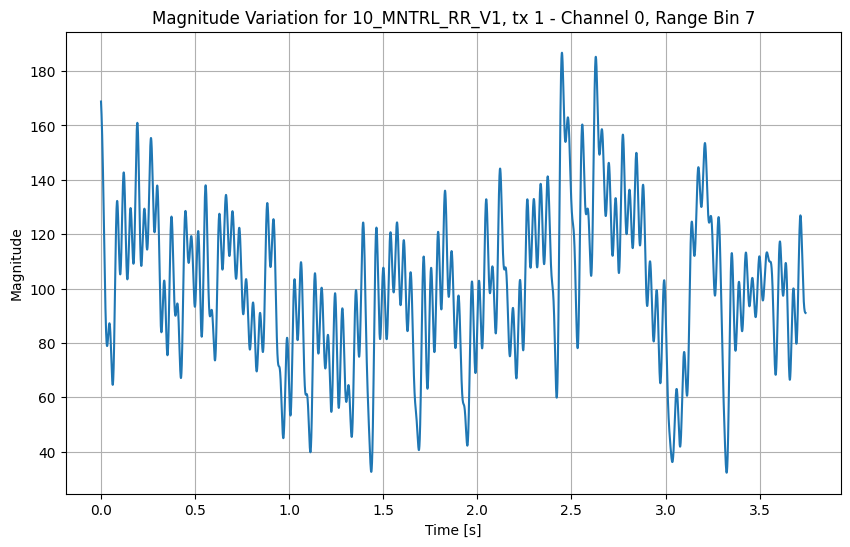

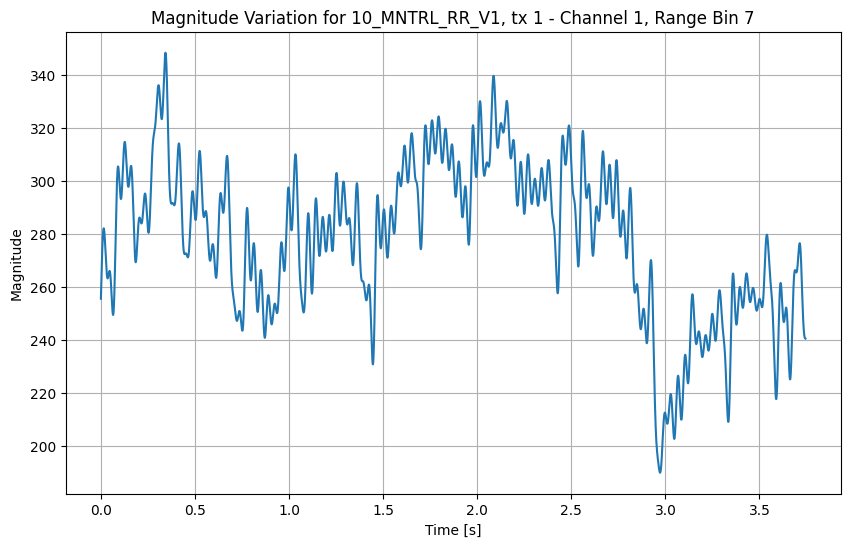

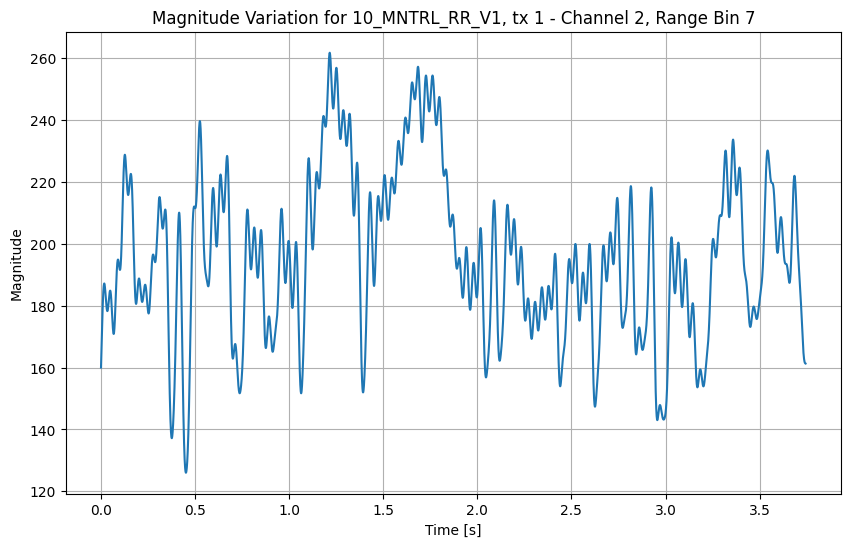

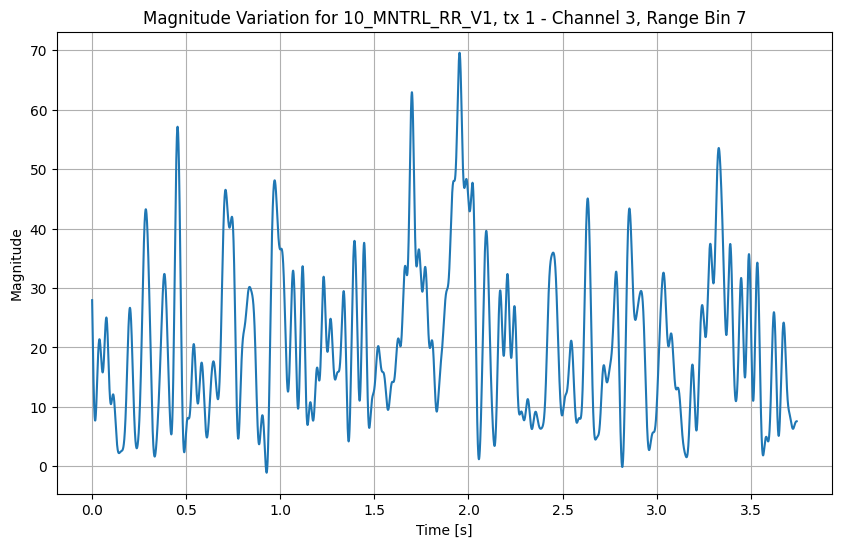

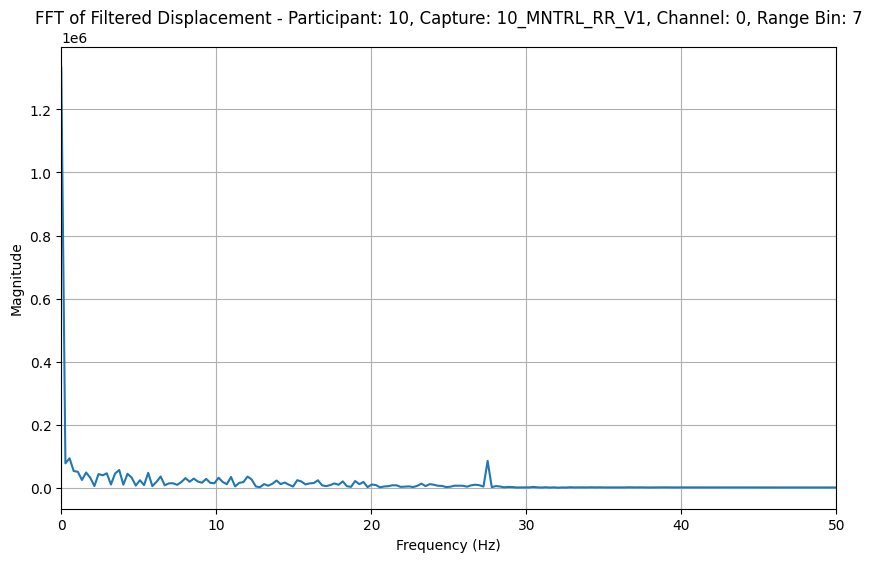

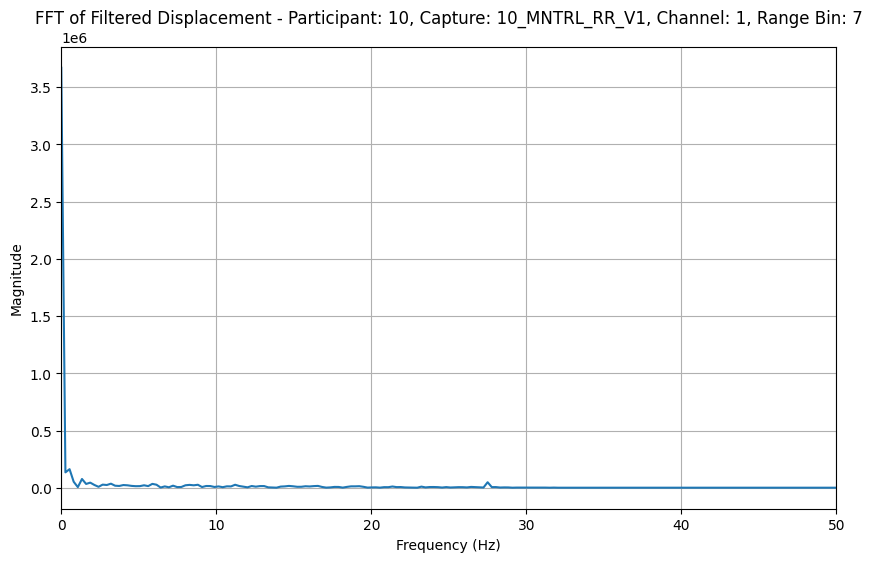

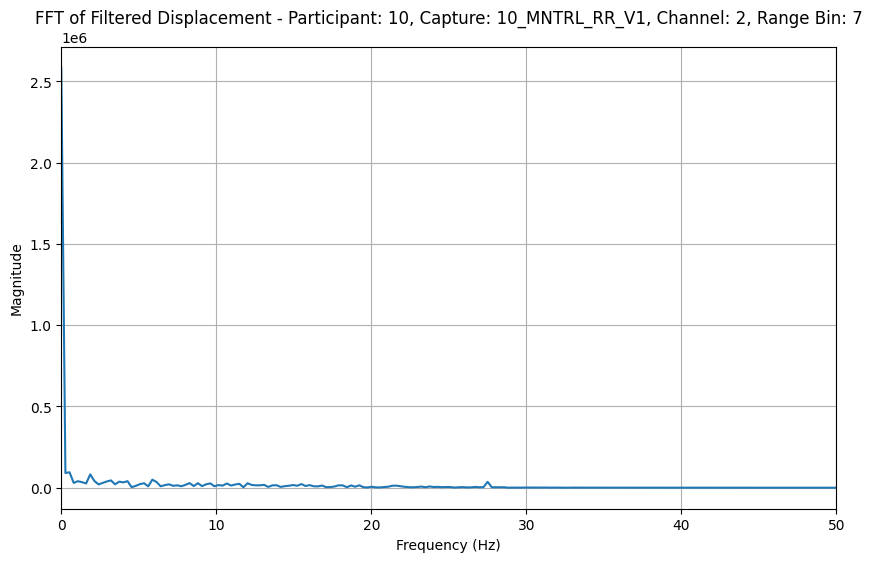

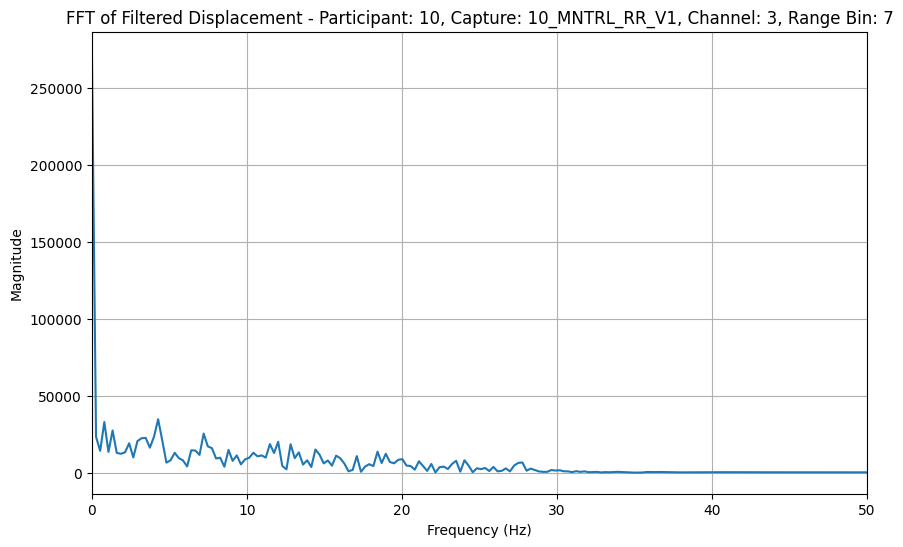

(4, 1000, 256, 128)


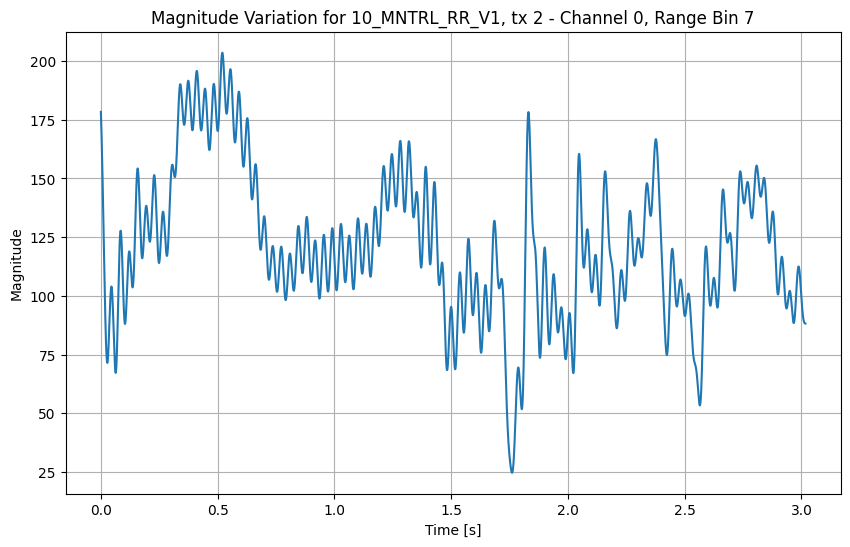

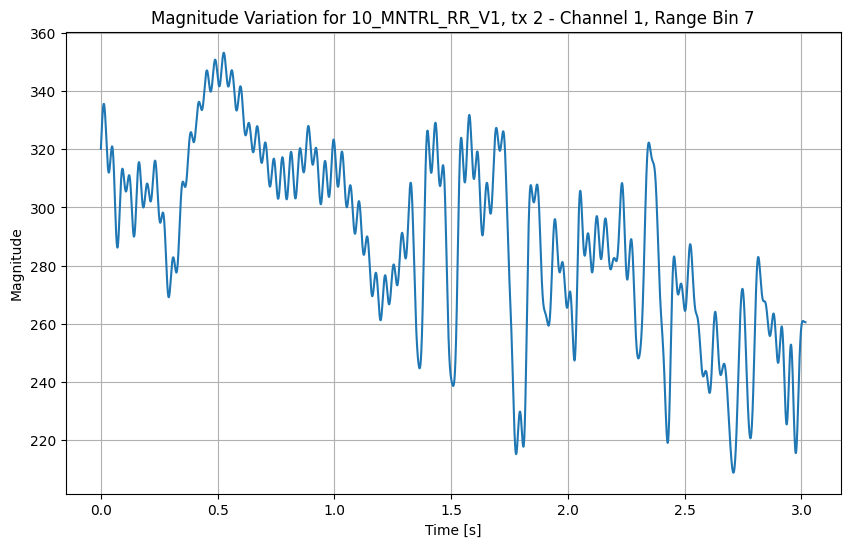

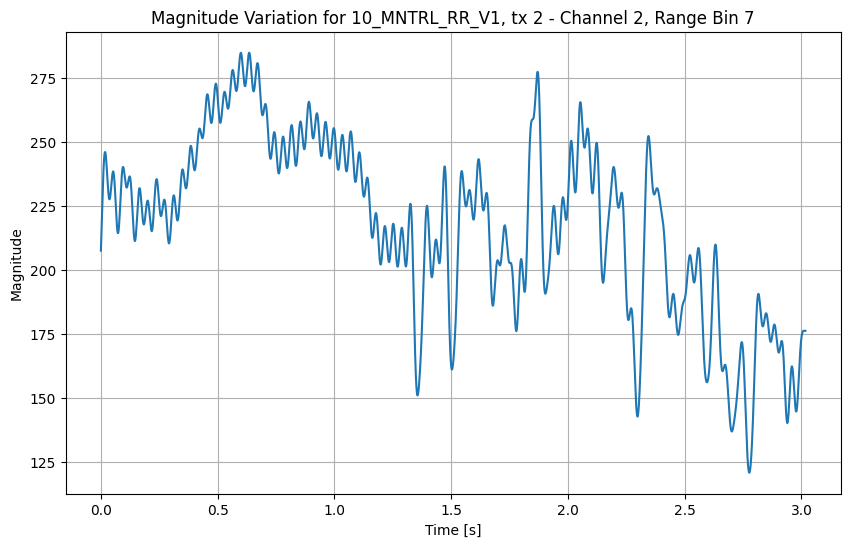

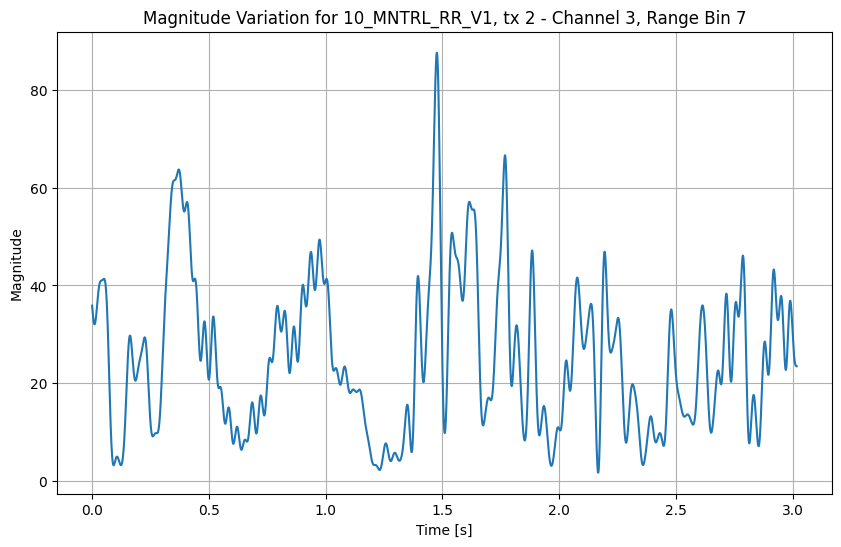

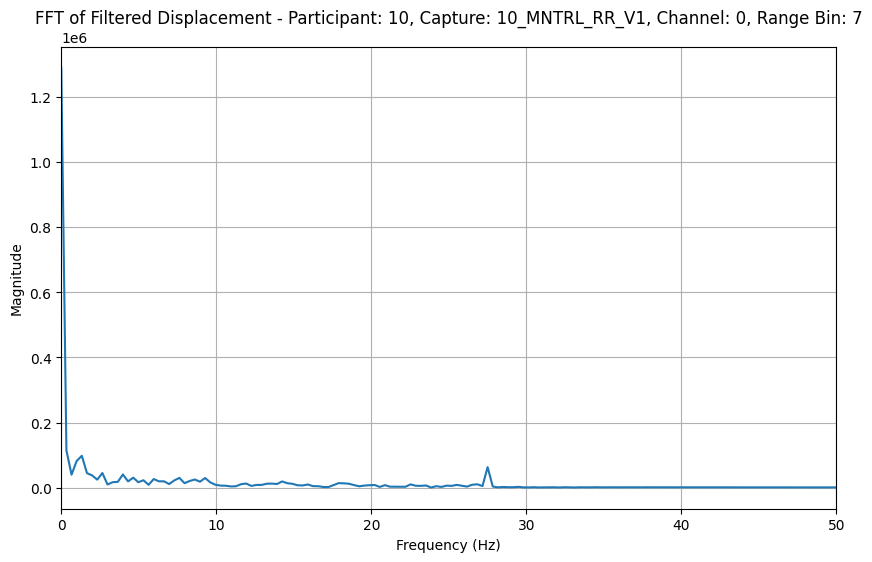

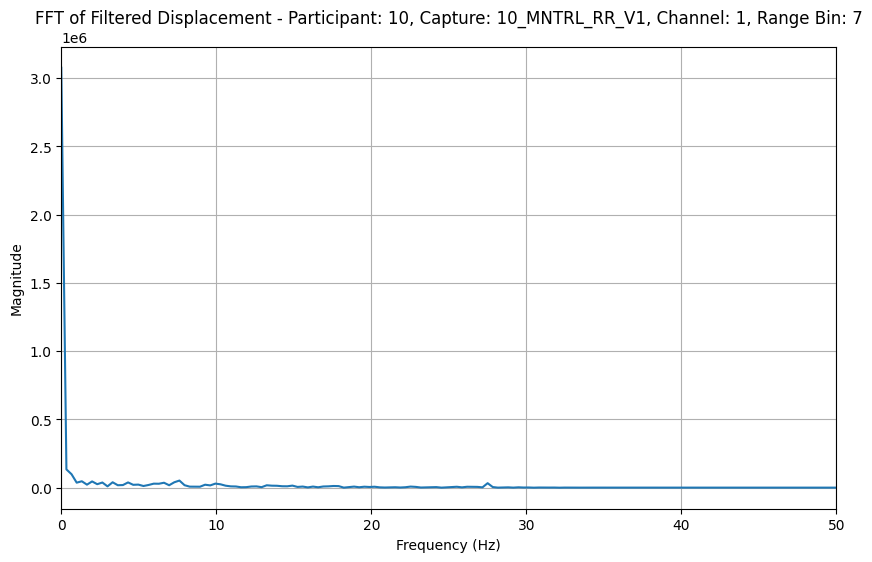

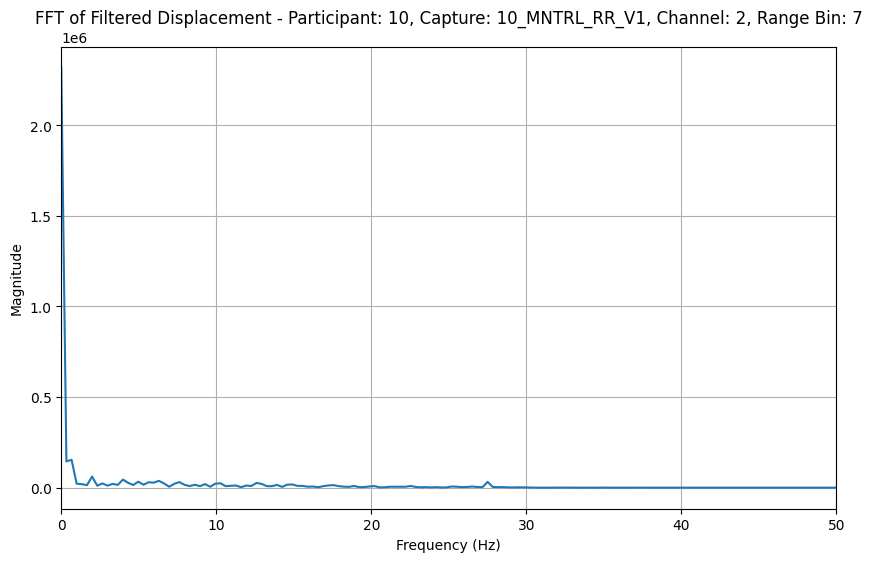

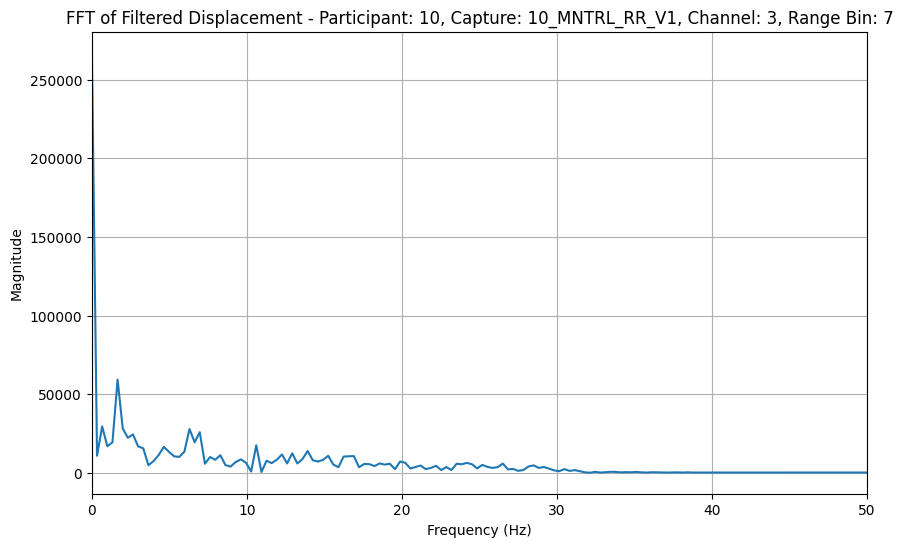

(4, 1000, 256, 128)


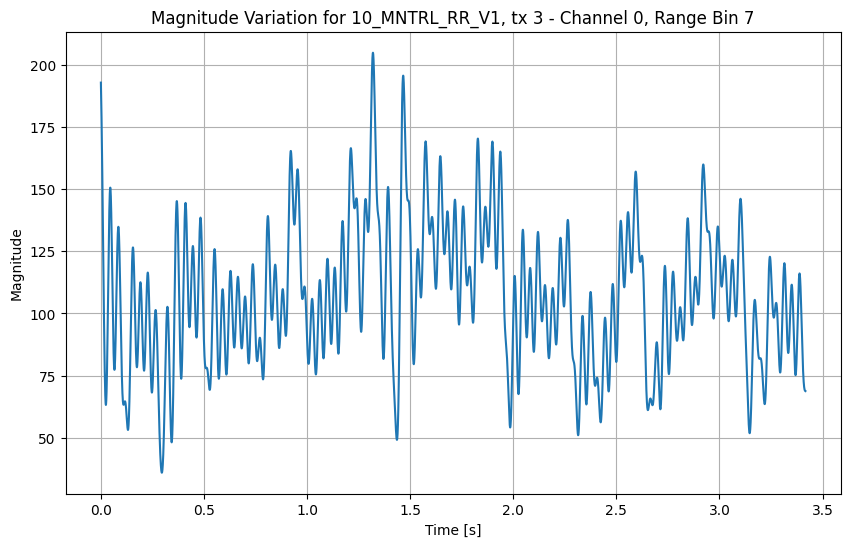

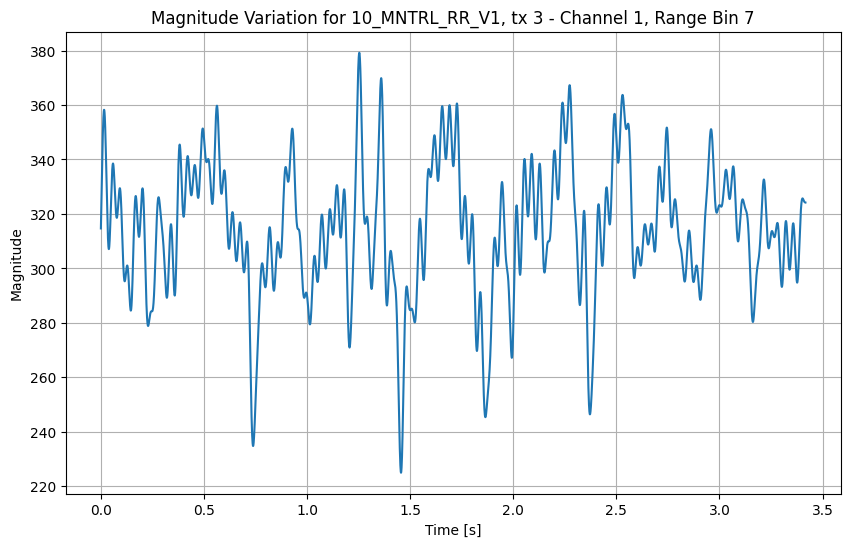

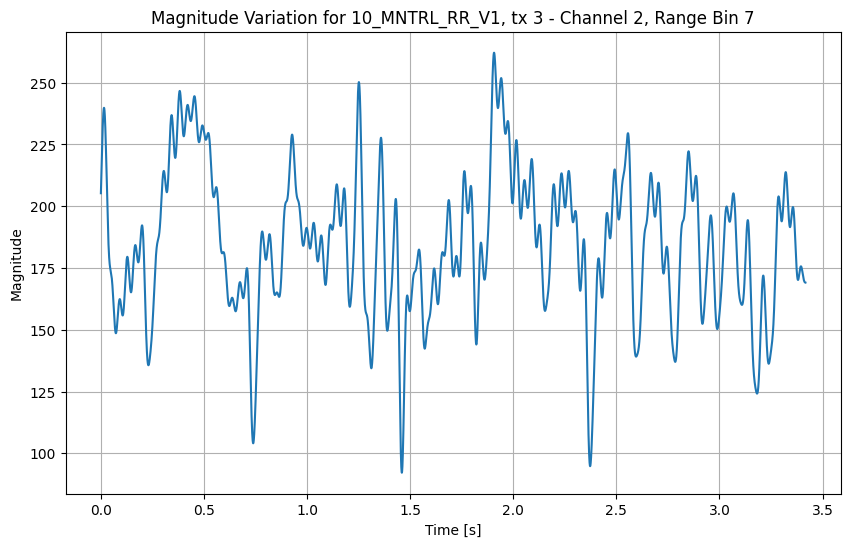

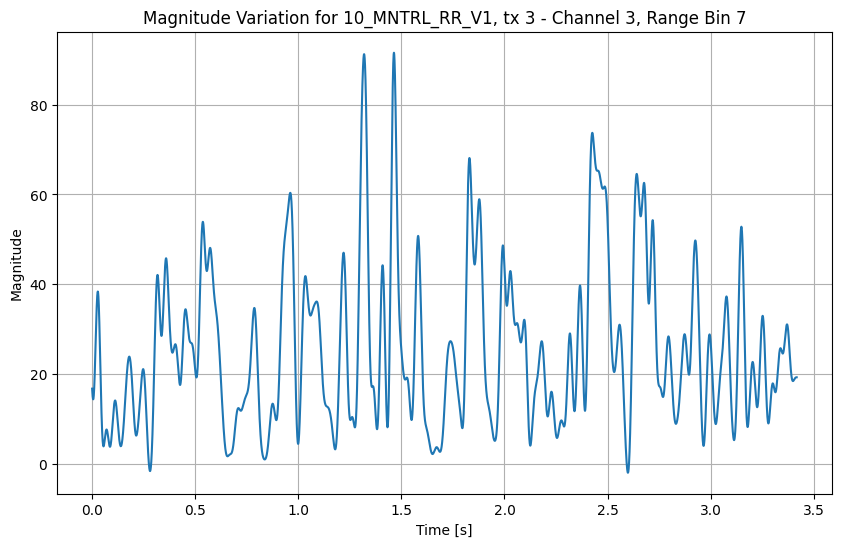

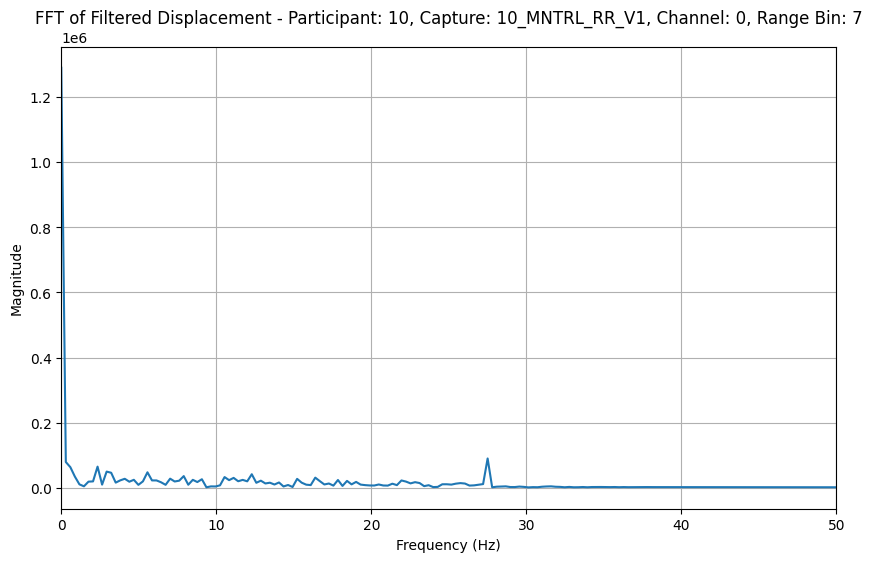

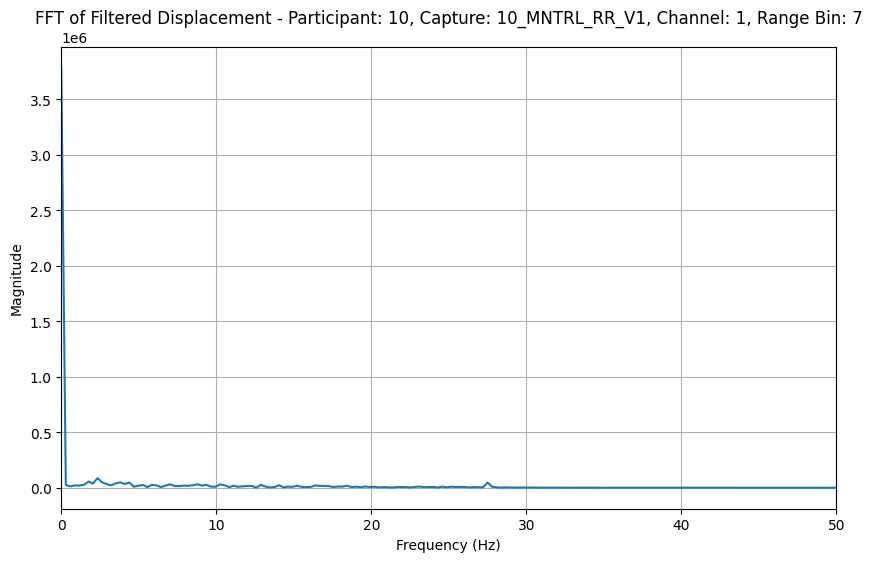

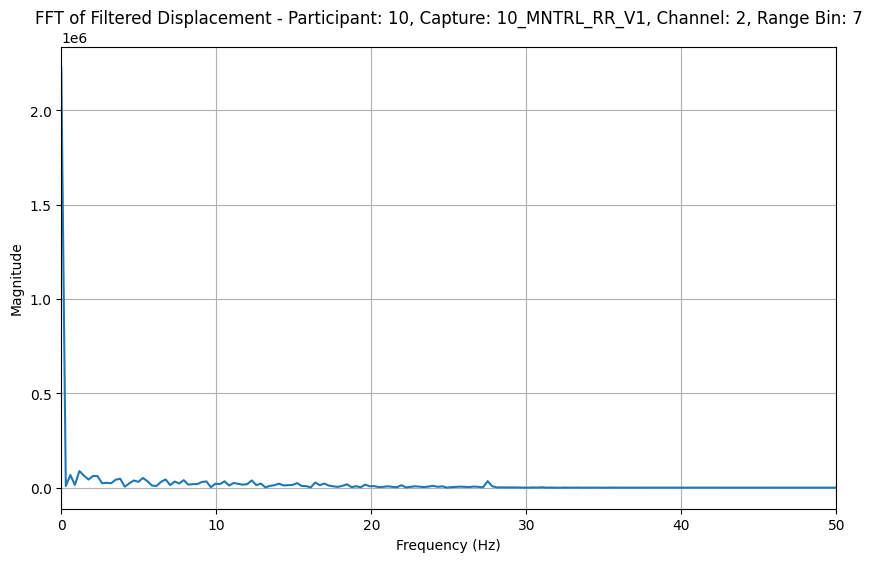

KeyboardInterrupt: 

In [3]:
import pandas as pd
import numpy as np

# Path to the CSV file containing time labels
fp_mocap_comparison_df_path = '/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/csvs/MOCAP_FP_RADAR_FU_Stable_Break_FD_TIME_FRAMES_v3.csv'
fp_mocap_comparison_df = pd.read_csv(fp_mocap_comparison_df_path)

print(fp_mocap_comparison_df.head())

problem_list = []
statistics = {}  # To store summary stats per participant

for index, row in fp_mocap_comparison_df.iterrows():
    capture_name = row['RADAR_capture']

    participant = capture_name[:2]
    if participant != "10" and participant != "15":  # Only analyzing participants 24 and 15
        continue

    radar_file_path = f"/Volumes/FourTBLaCie/Yoga_Study_RADAR_Data_Renamed/{participant}/{capture_name}.h5"

    # Handle special cases to skip certain captures or transitions
    if capture_name == '22_MNTRL_RR_V1' and str(row['tx']) == "3":
        continue
    elif capture_name == '24_MNTRR_RR_V1' and str(row['tx']) == "2":
        continue
    elif capture_name == '12_MNTRR_RR_V1':
        continue

    
    try:
        # Initialize the FMCWRADARDataCapture object
        RADAR_object = FMCWRADARDataCapture(file_path=radar_file_path)
    except Exception as e:
        problem_list.append((capture_name, row['tx'], e))
        continue

    # Load the data
    dataCubes = RADAR_object.load_and_save()
    print(dataCubes.shape)

    # Select frames between frame_stable and frame_end
    frame_stable = int(row['frame_stable'])
    if row['is_final_tx']:
        frame_end = int(row['frame_end'])
    else:
        frame_end = int(row['frame_break'])

    dataCubes_stable = dataCubes[:, frame_stable:frame_end, :, :]

    range_bins_of_interest = [7]

    # Compute the unwrapped phases or displacement
    displacements = RADAR_object.compute_magnitude_variation_by_bin(
        capture_name=capture_name,
        tx = row['tx'],
        dataCubes=dataCubes_stable,
        range_bins=range_bins_of_interest,
        plot=True  # We don't need to plot for every iteration
    ) 
    
    # Define filter parameters
    cutoff_frequency = 50.0  # Set the cutoff frequency for the low-pass filter in Hz

    # Compute summary statistics and FFT for each channel and range bin
    for channel in displacements:
        for range_bin in displacements[channel]:
            t, displacement = displacements[channel][range_bin]

            # Calculate the sampling frequency from the time data
            N = len(displacement)  # Number of samples
            T = t[1] - t[0]  # Sampling interval (time between samples)
            fs = 1 / T  # Sampling frequency

            # Apply low-pass filter to the displacement data
            filtered_displacement = lowpass_filter(displacement, cutoff_frequency, fs)

            # Calculate FFT of the filtered displacement signal
            fft_displacement = np.fft.fft(filtered_displacement)
            fft_freq = np.fft.fftfreq(N, T)  # Frequency bins

            # Keep only the positive frequencies
            fft_displacement = fft_displacement[:N // 2]
            fft_freq = fft_freq[:N // 2]

            # Compute magnitude of FFT
            fft_magnitude = np.abs(fft_displacement)

            # Plot the FFT results for each channel and range bin
            plt.figure(figsize=(10, 6))
            plt.plot(fft_freq, fft_magnitude)
            plt.title(f"FFT of Filtered Displacement - Participant: {participant}, Capture: {capture_name}, Channel: {channel}, Range Bin: {range_bin}")
            plt.xlabel("Frequency (Hz)")
            plt.xlim(0, 50)
            plt.ylabel("Magnitude")
            plt.grid(True)
            plt.show()

#             # Store statistics for further analysis
#             displacement_std = np.std(displacement)
#             displacement_range = np.ptp(displacement)  # Peak-to-Peak range

#             print(f"Participant: {participant}, Capture: {capture_name}, Channel: {channel}, Range Bin: {range_bin}")
#             print(f"Std Deviation: {displacement_std:.6f} m")
#             print(f"Range (Peak-to-Peak): {displacement_range:.6f} m")
#             print("-" * 50)

#             # Save the statistics for further analysis
#             if participant not in statistics:
#                 statistics[participant] = []

#             statistics[participant].append({
#                 'capture_name': capture_name,
#                 'channel': channel,
#                 'range_bin': range_bin,
#                 'std_deviation': displacement_std,
#                 'range_displacement': displacement_range
#             })

# # Convert the statistics into a DataFrame for further analysis
# wobble_statistics_df = pd.DataFrame([
#     {'participant': participant, **stat} for participant, stats_list in statistics.items() for stat in stats_list
# ])

# # Display the DataFrame
# print(wobble_statistics_df)


Wobble AUC

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to apply low-pass filter (assuming you have a function like this)
def lowpass_filter(data, cutoff, fs, order=4):
    from scipy.signal import butter, filtfilt
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Function to compute AUC (area under the curve) for a specific frequency range
def compute_auc(freq, magnitude, freq_range):
    # Find the indices corresponding to the frequency range
    freq_indices = (freq >= freq_range[0]) & (freq <= freq_range[1])
    # Compute the AUC (integral of the magnitude over the specified frequency range)
    auc_magnitude = np.trapz(magnitude[freq_indices], freq[freq_indices])
    return auc_magnitude

# Path to the CSV file containing time labels
fp_mocap_comparison_df_path = '/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/csvs/MOCAP_FP_RADAR_FU_Stable_Break_FD_TIME_FRAMES_v3.csv'
fp_mocap_comparison_df = pd.read_csv(fp_mocap_comparison_df_path)

problem_list = []
statistics = {}  # To store AUC stats per participant

for index, row in fp_mocap_comparison_df.iterrows():
    capture_name = row['RADAR_capture']
    participant = capture_name[:2]

    if participant not in ["10", "15"]:  # Only analyzing participants 10 and 15
        continue

    radar_file_path = f"/Volumes/FourTBLaCie/Yoga_Study_RADAR_Data_Renamed/{participant}/{capture_name}.h5"

    try:
        # Initialize the FMCWRADARDataCapture object
        RADAR_object = FMCWRADARDataCapture(file_path=radar_file_path)
    except Exception as e:
        problem_list.append((capture_name, row['tx'], e))
        continue

    # Load the data
    dataCubes = RADAR_object.load_and_save()

    # Select frames between frame_stable and frame_end
    frame_stable = int(row['frame_stable'])
    frame_end = int(row['frame_end']) if row['is_final_tx'] else int(row['frame_break'])

    dataCubes_stable = dataCubes[:, frame_stable:frame_end, :, :]

    range_bins_of_interest = [7]

    # Compute the unwrapped phases or displacement
    displacements = RADAR_object.compute_magnitude_variation_by_bin(
        capture_name=capture_name,
        tx=row['tx'],
        dataCubes=dataCubes_stable,
        range_bins=range_bins_of_interest,
        plot=False
    ) 
    
    # Define filter parameters
    cutoff_frequency = 50.0  # Low-pass filter cutoff frequency

    # Initialize AUC data for each participant
    auc_data = {}

    # Compute FFT, apply filter, and calculate AUC for each channel and range bin
    for channel in displacements:
        for range_bin in displacements[channel]:
            t, displacement = displacements[channel][range_bin]

            # Calculate the sampling frequency from the time data
            N = len(displacement)
            T = t[1] - t[0]  # Sampling interval
            fs = 1 / T  # Sampling frequency

            # Apply low-pass filter
            filtered_displacement = lowpass_filter(displacement, cutoff_frequency, fs)

            # Calculate FFT of the filtered displacement signal
            fft_displacement = np.fft.fft(filtered_displacement)
            fft_freq = np.fft.fftfreq(N, T)

            # Keep only the positive frequencies
            fft_displacement = fft_displacement[:N // 2]
            fft_freq = fft_freq[:N // 2]

            # Compute magnitude of FFT
            fft_magnitude = np.abs(fft_displacement)

            # Compute AUC between 0-5 Hz
            auc_0_5 = compute_auc(fft_freq, fft_magnitude, (0, 5))

            # Store AUC data for this participant, channel, and range bin
            if participant not in auc_data:
                auc_data[participant] = []
            auc_data[participant].append(auc_0_5)

            # Optionally plot the FFT
            plt.figure(figsize=(10, 6))
            plt.plot(fft_freq, fft_magnitude)
            plt.title(f"FFT of Filtered Displacement - Participant: {participant}, Capture: {capture_name}, Channel: {channel}, Range Bin: {range_bin}")
            plt.xlabel("Frequency (Hz)")
            plt.xlim(0, 50)
            plt.ylabel("Magnitude")
            plt.grid(True)
            plt.show()

    # Calculate the average AUC across all channels for this participant
    avg_auc = np.mean(auc_data[participant])
    print(f"Average AUC (0-5 Hz) for Participant {participant}: {avg_auc:.6f}")



(4, 103, 256, 128)
(4, 83, 256, 128)
(4, 94, 256, 128)
(4, 103, 256, 128)
(4, 100, 256, 128)
(4, 65, 256, 128)
(4, 97, 256, 128)
(4, 100, 256, 128)
(4, 88, 256, 128)
(4, 90, 256, 128)
(4, 101, 256, 128)
(4, 100, 256, 128)
(4, 96, 256, 128)
(4, 88, 256, 128)
(4, 95, 256, 128)
(4, 101, 256, 128)
(4, 97, 256, 128)
(4, 91, 256, 128)
(4, 95, 256, 128)
(4, 87, 256, 128)
(4, 94, 256, 128)
(4, 89, 256, 128)
(4, 93, 256, 128)
(4, 94, 256, 128)
(4, 90, 256, 128)
(4, 89, 256, 128)


KeyboardInterrupt: 

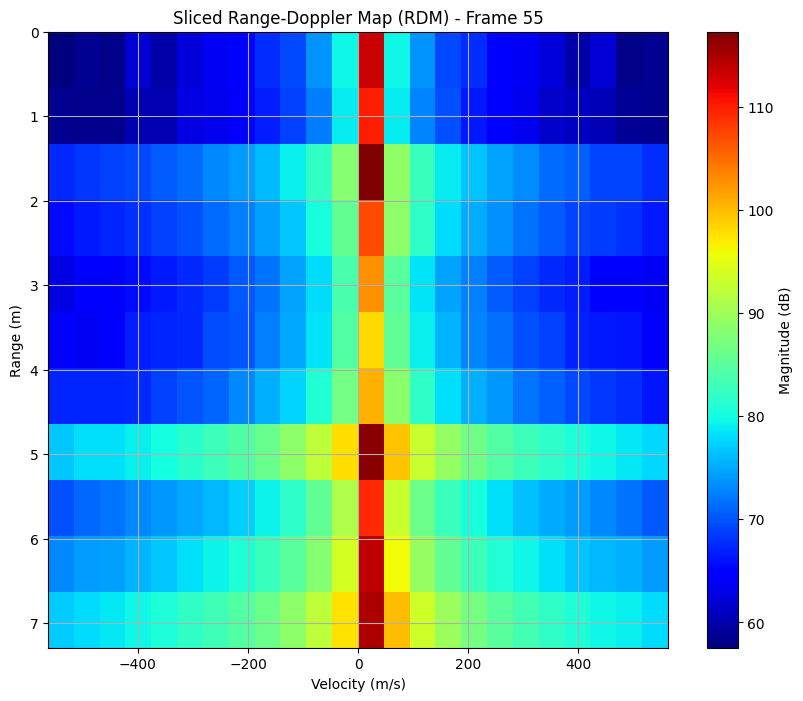

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu  # Import for statistical comparison

# Function to apply low-pass filter
def lowpass_filter(data, cutoff, fs, order=4):
    from scipy.signal import butter, filtfilt
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Function to compute AUC for a specific frequency range
def compute_auc(freq, magnitude, freq_range):
    # Find the indices corresponding to the frequency range
    freq_indices = (freq >= freq_range[0]) & (freq <= freq_range[1])
    # Compute the AUC (integral of the magnitude over the specified frequency range)
    auc_magnitude = np.trapz(magnitude[freq_indices], freq[freq_indices])
    return auc_magnitude

# Path to the CSV file containing time labels
fp_mocap_comparison_df_path = '/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/csvs/MOCAP_FP_RADAR_FU_Stable_Break_FD_TIME_FRAMES_v3.csv'
fp_mocap_comparison_df = pd.read_csv(fp_mocap_comparison_df_path)

problem_list = []
statistics = {}  # To store AUC stats per participant

auc_data = {'10': [], '15': []}  # To store AUCs for each participant

for index, row in fp_mocap_comparison_df.iterrows():
    capture_name = row['RADAR_capture']
    participant = capture_name[:2]

    if participant not in ["10", "15"]:  # Only analyzing participants 10 and 15
        continue

    radar_file_path = f"/Volumes/FourTBLaCie/Yoga_Study_RADAR_Data_Renamed/{participant}/{capture_name}.h5"

    try:
        # Initialize the FMCWRADARDataCapture object
        RADAR_object = FMCWRADARDataCapture(file_path=radar_file_path)
    except Exception as e:
        problem_list.append((capture_name, row['tx'], e))
        continue

    # Load the data
    dataCubes = RADAR_object.load_and_save()
    # Select frames between frame_stable and frame_end
    frame_stable = int(row['frame_stable'])
    frame_end = int(row['frame_end']) if row['is_final_tx'] else int(row['frame_break'])

    dataCubes_stable = dataCubes[:, frame_stable:frame_end, :, :]
    print(dataCubes_stable.shape)
    
    RADAR_object.synthesize_rdm(dataCubes_stable, plot=True)
    

Wobble Magnitude and AUC per channel

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu  # Import for statistical comparison

# Function to apply low-pass filter
def lowpass_filter(data, cutoff, fs, order=4):
    from scipy.signal import butter, filtfilt
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Function to compute AUC for a specific frequency range
def compute_auc(freq, magnitude, freq_range):
    # Find the indices corresponding to the frequency range
    freq_indices = (freq >= freq_range[0]) & (freq <= freq_range[1])
    # Compute the AUC (integral of the magnitude over the specified frequency range)
    auc_magnitude = np.trapz(magnitude[freq_indices], freq[freq_indices])
    return auc_magnitude

# Path to the CSV file containing time labels
fp_mocap_comparison_df_path = '/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/csvs/MOCAP_FP_RADAR_FU_Stable_Break_FD_TIME_FRAMES_v3.csv'
fp_mocap_comparison_df = pd.read_csv(fp_mocap_comparison_df_path)

problem_list = []
statistics = {}  # To store AUC stats per participant

auc_data = {'10': [], '15': []}  # To store AUCs for each participant

for index, row in fp_mocap_comparison_df.iterrows():
    capture_name = row['RADAR_capture']
    participant = capture_name[:2]

    if participant not in ["10", "15"]:  # Only analyzing participants 10 and 15
        continue

    radar_file_path = f"/Volumes/FourTBLaCie/Yoga_Study_RADAR_Data_Renamed/{participant}/{capture_name}.h5"

    try:
        # Initialize the FMCWRADARDataCapture object
        RADAR_object = FMCWRADARDataCapture(file_path=radar_file_path)
    except Exception as e:
        problem_list.append((capture_name, row['tx'], e))
        continue

    # Load the data
    dataCubes = RADAR_object.load_and_save()
    # Select frames between frame_stable and frame_end
    frame_stable = int(row['frame_stable'])
    frame_end = int(row['frame_end']) if row['is_final_tx'] else int(row['frame_break'])

    dataCubes_stable = dataCubes[:, frame_stable:frame_end, :, :]

    range_bins_of_interest = [7]

    # Compute the unwrapped phases or displacement
    displacements = RADAR_object.compute_magnitude_variation_by_bin(
        capture_name=capture_name,
        tx=row['tx'],
        dataCubes=dataCubes_stable,
        range_bins=range_bins_of_interest,
        plot=True  # Disable plotting
    ) 
    
    # Define filter parameters
    cutoff_frequency = 50.0  # Low-pass filter cutoff frequency

    specified_channel = 1
    
    # Compute FFT, apply filter, and calculate AUC for each channel and range bin
    for channel in displacements:
        if channel != specified_channel:  # Only process the specified channel
            continue  # Skip other channels
        for range_bin in displacements[channel]:
            t, displacement = displacements[channel][range_bin]

            # Calculate the sampling frequency from the time data
            N = len(displacement)
            T = t[1] - t[0]  # Sampling interval
            fs = 1 / T  # Sampling frequency

            # Apply low-pass filter
            filtered_displacement = lowpass_filter(displacement, cutoff_frequency, fs)

            # Calculate FFT of the filtered displacement signal
            fft_displacement = np.fft.fft(filtered_displacement)
            fft_freq = np.fft.fftfreq(N, T)

            # Keep only the positive frequencies
            fft_displacement = fft_displacement[:N // 2]
            fft_freq = fft_freq[:N // 2]

            # Compute magnitude of FFT
            fft_magnitude = np.abs(fft_displacement)

            # Compute AUC between 0-5 Hz
            auc_0_5 = compute_auc(fft_freq, fft_magnitude, (0, 5))
            print(auc_0_5)

            # Store AUC data for this participant
            auc_data[participant].append(auc_0_5)
            
            # Optionally plot the FFT
            plt.figure(figsize=(10, 6))
            plt.plot(fft_freq, fft_magnitude)
            plt.title(f"FFT of Filtered Displacement - Participant: {participant}, Capture: {capture_name}, Channel: {channel}, Range Bin: {range_bin}")
            plt.xlabel("Frequency (Hz)")
            plt.xlim(0, 50)
            plt.ylabel("Magnitude")
            plt.grid(True)
            plt.show()

# Statistical comparison between participant 10 and participant 15
participant_10_auc = auc_data['10']
participant_15_auc = auc_data['15']

# Perform Mann-Whitney U test (non-parametric test) to compare AUCs
stat, p_value = mannwhitneyu(participant_10_auc, participant_15_auc)

# Print results
print(f"AUC Comparison (0-5 Hz) between Participant 10 and 15:")
print(f"Participant 10 - Mean AUC: {np.mean(participant_10_auc):.6f}")
print(f"Participant 15 - Mean AUC: {np.mean(participant_15_auc):.6f}")
print(f"Mann-Whitney U Test p-value: {p_value:.6f}")

if p_value < 0.05:
    print("There is a statistically significant difference in wobble AUC between participants 10 and 15.")
else:
    print("No statistically significant difference in wobble AUC between participants 10 and 15.")


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt

# Function to apply low-pass filter
def lowpass_filter(data, cutoff, fs, order=4):
    from scipy.signal import butter, filtfilt
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Function to compute AUC for a specific frequency range
def compute_auc(freq, magnitude, freq_range):
    # Find the indices corresponding to the frequency range
    freq_indices = (freq >= freq_range[0]) & (freq <= freq_range[1])
    # Compute the AUC (integral of the magnitude over the specified frequency range)
    auc_magnitude = np.trapz(magnitude[freq_indices], freq[freq_indices])
    return auc_magnitude

# Path to the CSV file containing time labels
fp_mocap_comparison_df_path = '/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/csvs/MOCAP_FP_RADAR_FU_Stable_Break_FD_TIME_FRAMES_v3.csv'
fp_mocap_comparison_df = pd.read_csv(fp_mocap_comparison_df_path)

problem_list = []
statistics = {}  # To store AUC stats per participant

auc_data = {}  # To dynamically store AUCs for each participant

for index, row in fp_mocap_comparison_df.iterrows():
    capture_name = row['RADAR_capture']
    participant = capture_name[:2]
    
    # Handle special cases to skip certain captures or transitions
    if capture_name == '22_MNTRL_RR_V1' and str(row['tx']) == "3":
        continue
    elif capture_name == '24_MNTRR_RR_V1' and str(row['tx']) == "2":
        continue
    elif capture_name == '12_MNTRR_RR_V1':
        continue

    

    if participant not in auc_data:
        auc_data[participant] = []  # Initialize AUC list for the participant

    radar_file_path = f"/Volumes/FourTBLaCie/Yoga_Study_RADAR_Data_Renamed/{participant}/{capture_name}.h5"

    try:
        # Initialize the FMCWRADARDataCapture object
        RADAR_object = FMCWRADARDataCapture(file_path=radar_file_path)
    except Exception as e:
        problem_list.append((capture_name, row['tx'], e))
        continue

    # Load the data
    dataCubes = RADAR_object.load_and_save()
    # Select frames between frame_stable and frame_end
    frame_stable = int(row['frame_stable'])
    frame_end = int(row['frame_end']) if row['is_final_tx'] else int(row['frame_break'])

    dataCubes_stable = dataCubes[:, frame_stable:frame_end, :, :]

    range_bins_of_interest = [7]

    # Compute the unwrapped phases or displacement
    displacements = RADAR_object.compute_magnitude_variation_by_bin(
        capture_name=capture_name,
        tx=row['tx'],
        dataCubes=dataCubes_stable,
        range_bins=range_bins_of_interest,
        plot=False  # Disable plotting
    ) 
    
    # Define filter parameters
    cutoff_frequency = 50.0  # Low-pass filter cutoff frequency

    specified_channel = 1
    
    # Compute FFT, apply filter, and calculate AUC for each channel and range bin
    for channel in displacements:
        if channel != specified_channel:  # Only process the specified channel
            continue  # Skip other channels
        for range_bin in displacements[channel]:
            t, displacement = displacements[channel][range_bin]

            # Calculate the sampling frequency from the time data
            N = len(displacement)
            T = t[1] - t[0]  # Sampling interval
            fs = 1 / T  # Sampling frequency

            # Apply low-pass filter
            filtered_displacement = lowpass_filter(displacement, cutoff_frequency, fs)

            # Calculate FFT of the filtered displacement signal
            fft_displacement = np.fft.fft(filtered_displacement)
            fft_freq = np.fft.fftfreq(N, T)

            # Keep only the positive frequencies
            fft_displacement = fft_displacement[:N // 2]
            fft_freq = fft_freq[:N // 2]

            # Compute magnitude of FFT
            fft_magnitude = np.abs(fft_displacement)

            # Compute AUC between 0-5 Hz
            auc_0_5 = compute_auc(fft_freq, fft_magnitude, (0, 5))

            # Store AUC data for this participant
            auc_data[participant].append(auc_0_5)

# Compute mean AUC for each participant
mean_auc_per_participant = {participant: np.mean(auc_list) for participant, auc_list in auc_data.items()}

# Plotting the AUC comparison for all participants
plt.figure(figsize=(10, 6))
plt.bar(mean_auc_per_participant.keys(), mean_auc_per_participant.values(), color='skyblue')
plt.xlabel('Participants')
plt.ylabel('Mean AUC (0-5 Hz)')
plt.title('Mean AUC (0-5 Hz) Comparison Across Participants')
plt.grid(True)
plt.show()

# If you want, you can perform statistical comparisons (e.g., between specific participants)
# For example, between participant '10' and '15':
if '10' in auc_data and '15' in auc_data:
    participant_10_auc = auc_data['10']
    participant_15_auc = auc_data['15']
    
    # Perform Mann-Whitney U test (non-parametric test) to compare AUCs
    stat, p_value = mannwhitneyu(participant_10_auc, participant_15_auc)

    # Print results
    print(f"AUC Comparison (0-5 Hz) between Participant 10 and 15:")
    print(f"Participant 10 - Mean AUC: {np.mean(participant_10_auc):.6f}")
    print(f"Participant 15 - Mean AUC: {np.mean(participant_15_auc):.6f}")
    print(f"Mann-Whitney U Test p-value: {p_value:.6f}")

    if p_value < 0.05:
        print("There is a statistically significant difference in wobble AUC between participants 10 and 15.")
    else:
        print("No statistically significant difference in wobble AUC between participants 10 and 15.")


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# Function to compute FFT for COP or Force data
def compute_fft(data, sampling_rate):
    N = len(data)  # Number of data points
    T = 1 / sampling_rate  # Sampling interval
    fft_result = np.fft.fft(data)
    fft_freq = np.fft.fftfreq(N, T)

    # Keep only positive frequencies
    fft_result = fft_result[:N // 2]
    fft_freq = fft_freq[:N // 2]

    # Compute magnitude of FFT
    fft_magnitude = np.abs(fft_result)

    return fft_freq, fft_magnitude

# Function to compute AUC for a specified frequency range
def compute_auc(freq, magnitude, freq_range):
    freq_indices = (freq >= freq_range[0]) & (freq <= freq_range[1])
    auc_value = np.trapz(magnitude[freq_indices], freq[freq_indices])
    return auc_value

# Assuming the following is your loop that processes each participant's data
participants_auc = {}

for index, row in fp_mocap_comparison_df.iterrows():
    # Extract participant and capture names
    participant = row['RADAR_capture'][:2]
    MOCAP_capture_name = row['RADAR_capture'].replace('_RR_', '_MC_')
    base_file_path = f"/Volumes/FourTBLaCie/Yoga_Study_FP_1and2_MNTR/{participant}/{MOCAP_capture_name}.tsv"

    # Load COP or Force data
    force_plate_capture = FPDataCapture(base_file_path)
    
    if MOCAP_capture_name == '22_MNTRL_MC_V1' and str(row['tx']) == "3":
        continue
    elif MOCAP_capture_name == '24_MNTRR_MC_V1' and str(row['tx']) == "2":
        continue
    elif MOCAP_capture_name == '12_MNTRR_MC_V1':
        continue
    elif MOCAP_capture_name == '16_MNTRL_MC_V2' and str(row['tx']) == '3':
        continue
    
    # Select the correct COP or Force data
    if "MNTRR" in force_plate_capture.base_file_path:
        cop_data = force_plate_capture.data_f_1
    elif "MNTRL" in force_plate_capture.base_file_path:
        cop_data = force_plate_capture.data_f_2
    else:
        print(f"Unknown base file path format for sample {index}.")
        continue
    
    if row['is_final_tx']:
        t_start = row['t_stable']
        t_end = row['t_foot_down']
    else:
        t_start = row['t_stable']
        t_end = row['t_break']
    
    # Extract COP data for the relevant time interval
    cop_data_interval = cop_data[(cop_data['time'] >= t_start) & (cop_data['time'] <= t_end)]
    
    # Calculate sampling rate
    time_series = cop_data_interval['time'].values
    sampling_rate = 1 / (time_series[1] - time_series[0])  # Sampling rate from time intervals

    # Extract the component of COP or Force data you want to analyze (e.g., COP_X)
    cop_x = cop_data_interval['COP_X'].values

    # Compute FFT for COP_X
    fft_freq_cop_x, fft_magnitude_cop_x = compute_fft(cop_x, sampling_rate)

    # Compute AUC between 0-5 Hz
    auc_0_5 = compute_auc(fft_freq_cop_x, fft_magnitude_cop_x, (0, 5))
    
    # Store the AUC for the participant
    if participant not in participants_auc:
        participants_auc[participant] = []
    participants_auc[participant].append(auc_0_5)

# Calculate the average AUC for each participant
average_auc = {participant: np.mean(auc_list) for participant, auc_list in participants_auc.items()}

# # Plot a bar chart for average AUC by participant
# plt.figure(figsize=(10, 6))
# plt.bar(average_auc.keys(), average_auc.values())
# plt.title("Average AUC (0-5 Hz) by Participant")
# plt.xlabel("Participant")
# plt.ylabel("Average AUC")
# plt.grid(True)
# plt.show()

# Optional: Statistical comparison between participants
participants = list(participants_auc.keys())
if len(participants) >= 2:
    participant_1_auc = participants_auc[participants[0]]
    participant_2_auc = participants_auc[participants[1]]

    # Perform Mann-Whitney U test
    stat, p_value = mannwhitneyu(participant_1_auc, participant_2_auc)

    print(f"AUC Comparison (0-5 Hz) between Participant {participants[0]} and {participants[1]}:")
    print(f"Participant {participants[0]} - Mean AUC: {np.mean(participant_1_auc):.6f}")
    print(f"Participant {participants[1]} - Mean AUC: {np.mean(participant_2_auc):.6f}")
    print(f"Mann-Whitney U Test p-value: {p_value:.6f}")

    if p_value < 0.05:
        print(f"There is a statistically significant difference in wobble AUC between Participant {participants[0]} and {participants[1]}.")
    else:
        print(f"No statistically significant difference in wobble AUC between Participant {participants[0]} and {participants[1]}.")


In [ ]:

# Assuming the following is your loop that processes each participant's data
participants_auc = {}

for index, row in fp_mocap_comparison_df.iterrows():
    # Extract participant and capture names
    participant = row['RADAR_capture'][:2]
    MOCAP_capture_name = row['RADAR_capture'].replace('_RR_', '_MC_')
    base_file_path = f"/Volumes/FourTBLaCie/Yoga_Study_FP_1and2_MNTR/{participant}/{MOCAP_capture_name}.tsv"

    # Load COP or Force data
    force_plate_capture = FPDataCapture(base_file_path)
    
    if MOCAP_capture_name == '22_MNTRL_MC_V1' and str(row['tx']) == "3":
        continue
    elif MOCAP_capture_name == '24_MNTRR_MC_V1' and str(row['tx']) == "2":
        continue
    elif MOCAP_capture_name == '12_MNTRR_MC_V1':
        continue
    elif MOCAP_capture_name == '16_MNTRL_MC_V2' and str(row['tx']) == '3':
        continue
    
    # Select the correct COP or Force data
    if "MNTRR" in force_plate_capture.base_file_path:
        cop_data = force_plate_capture.data_f_1
    elif "MNTRL" in force_plate_capture.base_file_path:
        cop_data = force_plate_capture.data_f_2
    else:
        print(f"Unknown base file path format for sample {index}.")
        continue
    
    if row['is_final_tx']:
        t_start = row['t_stable']
        t_end = row['t_foot_down']
    else:
        t_start = row['t_stable']
        t_end = row['t_break']
    
    # Extract COP data for the relevant time interval
    cop_data_interval = cop_data[(cop_data['time'] >= t_start) & (cop_data['time'] <= t_end)]
    
    # Calculate sampling rate
    time_series = cop_data_interval['time'].values
    sampling_rate = 1 / (time_series[1] - time_series[0])  # Sampling rate from time intervals

    # Extract the component of COP or Force data you want to analyze (e.g., COP_X)
    z_force = cop_data_interval['Force_Z'].values

    # Compute FFT for COP_X
    fft_freq_z_force, fft_magnitude_z_force = compute_fft(z_force, sampling_rate)

    # Compute AUC between 0-5 Hz
    auc_0_5 = compute_auc(fft_freq_z_force, fft_magnitude_z_force, (0, 5))
    
    # Store the AUC for the participant
    if participant not in participants_auc:
        participants_auc[participant] = []
    participants_auc[participant].append(auc_0_5)

# Calculate the average AUC for each participant
average_auc = {participant: np.mean(auc_list) for participant, auc_list in participants_auc.items()}

# # Plot a bar chart for average AUC by participant
# plt.figure(figsize=(10, 6))
# plt.bar(average_auc.keys(), average_auc.values())
# plt.title("Average AUC (0-5 Hz) by Participant")
# plt.xlabel("Participant")
# plt.ylabel("Average AUC")
# plt.grid(True)
# plt.show()

# Optional: Statistical comparison between participants
participants = list(participants_auc.keys())
if len(participants) >= 2:
    participant_1_auc = participants_auc[participants[0]]
    participant_2_auc = participants_auc[participants[1]]

    # Perform Mann-Whitney U test
    stat, p_value = mannwhitneyu(participant_1_auc, participant_2_auc)

    print(f"AUC Comparison (0-5 Hz) between Participant {participants[0]} and {participants[1]}:")
    print(f"Participant {participants[0]} - Mean AUC: {np.mean(participant_1_auc):.6f}")
    print(f"Participant {participants[1]} - Mean AUC: {np.mean(participant_2_auc):.6f}")
    print(f"Mann-Whitney U Test p-value: {p_value:.6f}")

    if p_value < 0.05:
        print(f"There is a statistically significant difference in wobble AUC between Participant {participants[0]} and {participants[1]}.")
    else:
        print(f"No statistically significant difference in wobble AUC between Participant {participants[0]} and {participants[1]}.")


In [ ]:
def normalize_force_z(force_z, weight):
    # Normalize Force_Z by the participant's weight to account for differences in mass
    return force_z / weight

# Assuming 'weights' is a dictionary with participant IDs as keys and their weights in Newtons (N) or kg.
# You would need to have a separate dataset with participant weights.

for index, row in fp_mocap_comparison_df.iterrows():
    
    # Extract participant and capture names
    participant = row['RADAR_capture'][:2]
    MOCAP_capture_name = row['RADAR_capture'].replace('_RR_', '_MC_')
    base_file_path = f"/Volumes/FourTBLaCie/Yoga_Study_FP_1and2_MNTR/{participant}/{MOCAP_capture_name}.tsv"

    # Load COP or Force data
    force_plate_capture = FPDataCapture(base_file_path)
    
    # Select the correct COP or Force data
    if "MNTRR" in force_plate_capture.base_file_path:
        cop_data = force_plate_capture.data_f_1
    elif "MNTRL" in force_plate_capture.base_file_path:
        cop_data = force_plate_capture.data_f_2
    else:
        continue
    
    # Extract relevant time interval
    t_start = row['t_stable']
    t_end = row['t_foot_down'] if row['is_final_tx'] else row['t_break']
    cop_data_interval = cop_data[(cop_data['time'] >= t_start) & (cop_data['time'] <= t_end)]
    
    # Normalize Force_Z using the participant's weight
    force_z = cop_data_interval['Force_Z'].values
    weight = np.mean(force_z)  # Get the weight for the current participant
    normalized_force_z = normalize_force_z(force_z, weight)
    
    # Proceed with FFT of the normalized force data
    fft_freq_force_z, fft_magnitude_force_z = compute_fft(normalized_force_z, sampling_rate)

    # Plot the normalized Force_Z FFT (optional)
    plt.figure(figsize=(10, 6))
    plt.plot(fft_freq_force_z, fft_magnitude_force_z)
    plt.title(f"FFT of Normalized Force_Z - Participant: {participant}, Capture: {MOCAP_capture_name}")
    plt.xlabel("Frequency (Hz)")
    plt.xlim(1, 10)
    plt.ylim(0, 50)
    plt.ylabel("Normalized Magnitude")
    plt.grid(True)
    plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Assuming participants_auc is a dictionary with participant IDs as keys and AUCs as values.
# Example format: participants_auc = {'01': {'0-2Hz': [list of AUCs], '2-5Hz': [list of AUCs]}, ...}

# Prepare data for box plot (0-2 Hz)
data_0_5 = [participants_auc[participant] for participant in participants]

# Create box plot for AUC (0-2 Hz)
plt.figure(figsize=(12, 6))
plt.boxplot(data_0_5, labels=participants)
plt.xlabel('Participant')
plt.ylabel('AUC (0-5 Hz)')
plt.title('Box Plot of AUC (0-5 Hz) by Participant')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming participants_auc is a dictionary with participant IDs as keys and AUCs as values.
# Example format: participants_auc = {'01': [list of AUCs], '02': [list of AUCs], ...}

# Compute the average AUC for each participant
participants = list(participants_auc.keys())
average_aucs = [np.mean(participants_auc[participant]) for participant in participants]

# Create a bar plot of the average AUCs
plt.figure(figsize=(10, 6))
plt.bar(participants, average_aucs, color='skyblue')
plt.xlabel('Participant')
plt.ylabel('Average AUC (0-5 Hz)')
plt.title('Average AUC (0-5 Hz) by Participant')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add the exact AUC value above each bar
for i, auc in enumerate(average_aucs):
    plt.text(i, auc + 0.01 * auc, f'{auc:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# Assuming participants_auc contains AUC data per participant
# Example format: participants_auc = {'01': [list of AUCs], '02': [list of AUCs], ...}

# Create a matrix to store the p-values for each pair of participants
participants = list(participants_auc.keys())
num_participants = len(participants)
p_value_matrix = np.ones((num_participants, num_participants))  # Initialize with 1s (default non-significance)

# Perform pairwise statistical comparisons
for i, participant_1 in enumerate(participants):
    for j, participant_2 in enumerate(participants):
        if i >= j:
            continue  # Only compute the upper triangle of the matrix, as comparisons are symmetric

        # Perform Mann-Whitney U test
        participant_1_auc = participants_auc[participant_1]
        participant_2_auc = participants_auc[participant_2]
        stat, p_value = mannwhitneyu(participant_1_auc, participant_2_auc)

        # Store the p-value in the matrix
        p_value_matrix[i, j] = p_value
        p_value_matrix[j, i] = p_value  # Symmetric matrix

# Create a custom colormap where values > 0.1 have no color shift, 
# values between 0.05 and 0.1 are slightly shifted, and values below 0.05 are strongly shifted.
def custom_colormap(val, cmap="coolwarm"):
    if val.any() > 0.1:
        return [1, 1, 1]  # white for non-significant values
    elif 0.05 < val <= 0.1:
        return [0.9, 0.9, 0.6]  # light yellow for near-significant values
    elif val <= 0.05:
        return [0.6, 0.2, 0.2]  # dark red for significant values

# Apply the colormap function to the p-value matrix
color_matrix = np.apply_along_axis(custom_colormap, 1, p_value_matrix)

# Plot the p-value matrix as a heatmap with the custom colors
plt.figure(figsize=(10, 8))
sns.heatmap(p_value_matrix, annot=True, xticklabels=participants, yticklabels=participants, cmap='coolwarm', mask=p_value_matrix > 0.1, fmt=".3f")
plt.title("Pairwise Mann-Whitney U Test P-Values (AUC Comparison)")
plt.xlabel("Participant")
plt.ylabel("Participant")
plt.show()

# Optional: Interpret significant results (e.g., p-value < 0.05)
print("Significant differences in AUC (p < 0.05):")
for i, participant_1 in enumerate(participants):
    for j, participant_2 in enumerate(participants):
        if i >= j:
            continue  # Avoid redundant comparisons
        if p_value_matrix[i, j] < 0.05:
            print(f"Significant difference between Participant {participant_1} and Participant {participant_2} (p = {p_value_matrix[i, j]:.3f})")
